## LL

In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
save_dir = '/home/hanna/images_simple_statsmodels/'
sat_dir = '/home/hanna/lagrings/satelite_data_raw/'

ex_fil = glob.glob(save_dir + '*indexes_test*.json')[0]
with open(ex_fil, 'r') as f:
    data_grid = json.load(f)

In [3]:
satfil = glob.glob(sat_dir + '*2012*10*.grb')[0]

In [4]:
cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')

ecCodes provides no latitudes/longitudes for gridType='space_view'


In [5]:
np.sqrt(13778944)

3712.0

In [6]:
o = cloudMask['p260537'].values.reshape( (3712, 3712) )

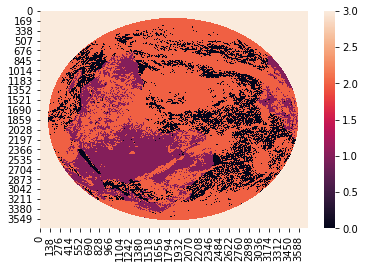

In [7]:
import seaborn as sns
sns.heatmap(o)

In [8]:
o[o>=3.0]=np.nan
o[o==1.0]=0
o[o==2.0]=1.0

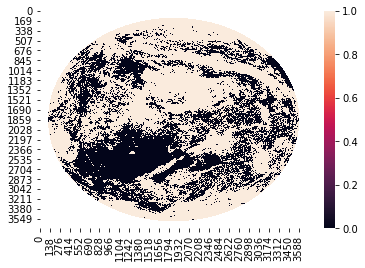

In [9]:
sns.heatmap(o)

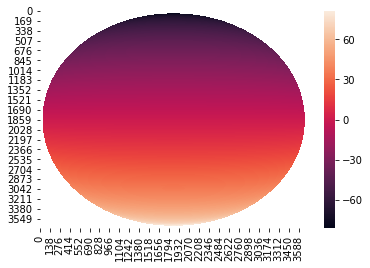

In [14]:
sns.heatmap(np.array(lat_array).reshape(3712, 3712))

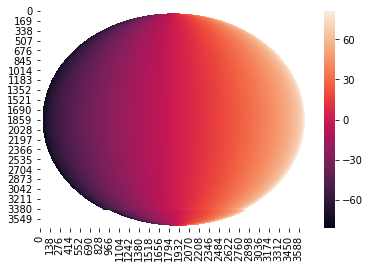

In [15]:
sns.heatmap(np.array(lon_array).reshape(3712, 3712))

In [11]:
def clean_cloud_mask():
    cmk = cloudMask['p260537'].values
    return 

In [12]:
def read_dlon_dlat(save_dir):
    nc_files = glob.glob(save_dir+'*cell*.json')
    #print(nc_files)
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    #save_dict_to_json(d, "changes_lat_lon_cell-area.json", save_dir = save_dir)
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [13]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)

In [19]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [20]:
ex_fil = glob.glob(save_dir + '*indexes_test*.json')[0]
with open(ex_fil, 'r') as f:
    data_grid = json.load(f)

In [21]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
lat = '30.25'
lon = '19.25'
clouds = o.reshape(-1)

def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = clouds):
    
    ## Improvements :: This should read the files. 
    ex1 = data_grid[lat][lon]
    fraction = 0

    ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
    SAT_area = 0
    #cmk = np.random.randint(low = 0, high=2, size = len(lat_array))

    for key, item in ex1.items():
        index = item['index']
        area  = item['area']

        SAT_area += np.sum(area)
        fraction += np.sum(np.array(area)*np.array(cmk[index]) )

    return fraction/SAT_area*ERA_area
    
    
   

In [22]:
calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = clouds)

0.5703278618712264

In [23]:
calc_fraction_one_cell(lat = '30.25', lon = '19.0', cmk = clouds)

0.9439413492795918